### Stereo Disparity 02

##### Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from helper import *
from skimage.metrics import structural_similarity

##### Loading images and true disparity maps

Left Camera Matrix
[[1.73374e+03 0.00000e+00 7.92270e+02]
 [0.00000e+00 1.73374e+03 5.41890e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Right Camera Matrix
[[1.73374e+03 0.00000e+00 7.92270e+02]
 [0.00000e+00 1.73374e+03 5.41890e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Baseline: 536.62
Image Size (Width, Height): (1920.0, 1080.0)
Conservative Bound of Disparity Levels: [0, 169.0]
Tight Bound of Min and Max Disparities: [55.0, 142.0]


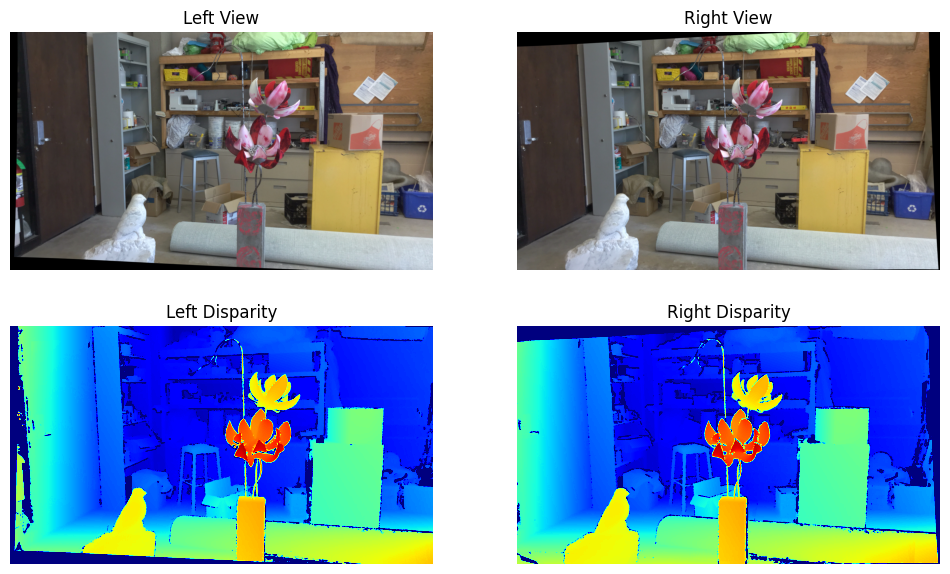

In [2]:
path = "2021 mobile datasets/artroom1"

calib = read_calib( f"{ path}/calib.txt")
disp_L, scale = read_pfm( f"{ path}/disp0.pfm")
disp_R, _ = read_pfm( f"{ path}/disp1.pfm")
img_L_orig = Image.open( f"{ path}/im0.png")
img_R_orig = Image.open( f"{ path}/im1.png")
img_L = np.array( img_L_orig.convert( "L"))
img_R = np.array( img_R_orig.convert( "L"))

print_calib( calib)

display( img_L_orig, img_R_orig, disp_L, disp_R, scale, calib[ "vmin"], calib[ "vmax"])

##### Compute disparity using block matching function of opencv

In [3]:
stereo = cv2.StereoBM_create( numDisparities=176, blockSize=7)
disparity = stereo.compute( img_L, img_R)

##### Scale the range of disparity into [0-1]

In [4]:
disparity = np.float32( disparity - disparity.min()) / np.float32( disparity.max())

disp_L_scaled = np.float32( disp_L - disp_L.min()) / np.float32( disp_L.max())

disp_R_scaled = np.float32( disp_R - disp_R.min()) / np.float32( disp_R.max())

##### Showing disparity

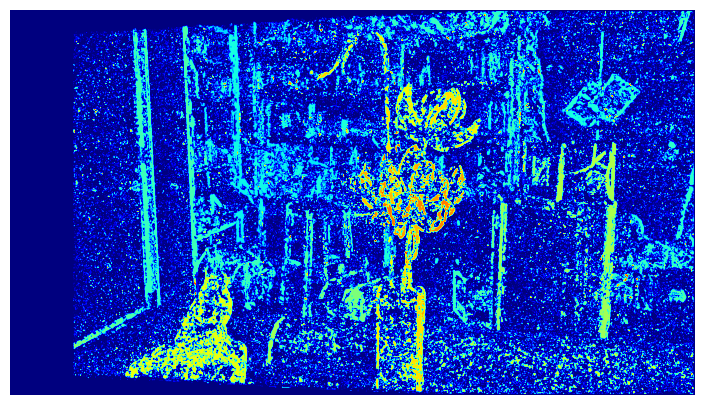

In [5]:
plt.figure( figsize=( 10, 5))
plt.imshow( disparity, cmap="jet")
plt.axis( "off")
plt.show()

##### Compute SSIM

In [6]:
ssim_L = structural_similarity( disparity, disp_L_scaled, data_range=1)
ssim_R = structural_similarity( disparity, disp_R_scaled, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

SSIM with Left Disparity: 0.05692042852500073
SSIM with Right Disparity: 0.041388353608499226
Mean SSIM: 0.04915439106674998


##### Implementation of block matching algorithm

##### Filter function

In [7]:
# params:
# 	a: Src
# 	b: Kernel
# 	cost: Matching Cost Function
# returns:
#	x: location corresponding to the minimum value of cost
def filter( a, b, cost):
	_, s_w = a.shape
	_, k_w = b.shape

	R = np.zeros( s_w - k_w + 1)

	for i in range( s_w - k_w + 1):
		R[ i] = cost( a[ :, i: i + k_w], b)

	x = np.argmin( R)
	
	x = int( x + ( k_w / 2))

	return x

##### Matching cost functions

- SAD (Sum of Absolute Difference)

In [8]:
def SAD( a, b):
	c = np.abs( np.array( a) - np.array( b))
	return c.sum()

- SSD (Sum of Squared Difference)

In [9]:
def SSD( a, b):
	c = np.square( np.array( a) - np.array( b))
	return c.sum()

- NCC (Normalized Cross Correlation)

In [10]:
def NCC( a, b):
	c = cv2.matchTemplate( np.float32( a), np.float32( b), cv2.TM_CCORR_NORMED)
	# negate the result because filter function looks for minimum value
	return -np.max( c)

- LoG (Laplacian of Gaussian) and SAD

In [11]:
def LoG_SAD( a, b):
	a = cv2.Laplacian( np.float64( a), cv2.CV_64F)
	b = cv2.Laplacian( np.float64( b), cv2.CV_64F)

	return SAD( a, b)

- LoG (Laplacian of Gaussian) and SSD

In [12]:
def LoG_SSD( a, b):
	a = cv2.Laplacian( np.float64( a), cv2.CV_64F)
	b = cv2.Laplacian( np.float64( b), cv2.CV_64F)

	return SSD( a, b)

##### Block matching algorithm

In [13]:
# params:
# 	left: Left Image
# 	right: Right Image
# 	cost: Matching Cost Function
#	numDisparity: Disparity Range
#	ksize: Size of the Kernel
# returns:
#	D: Disparity Map
def block_matching( left, right, cost, numDisparity, ksize=3):
	height, width = left.shape

	# Radius of Kernel
	r = int( ksize / 2)

	D = np.zeros( ( height, width))

	for i in range( height):
		for j in range( width):
			# Region Of Interest in Left Image
			roi_height_low = i - r if i - r > -1 else 0
			roi_width_low = j - r if j - r > -1 else 0

			# Select Out the Region from Left Image
			roi = left[ roi_height_low: i + r + 1, roi_width_low: j + r + 1]

			# Select Out the Area of Search from Right Image
			area = right[ roi_height_low: i + r + 1, roi_width_low: j + numDisparity + 1]

			# Finding the Middle of 
			_, area_middle = area.shape

			# Apply Filter with Desired Cost Function
			s = filter( area, roi, cost)

			# Displacement
			u = s - r

			D[ i][ j] = u
	
	return D

##### Resizing images

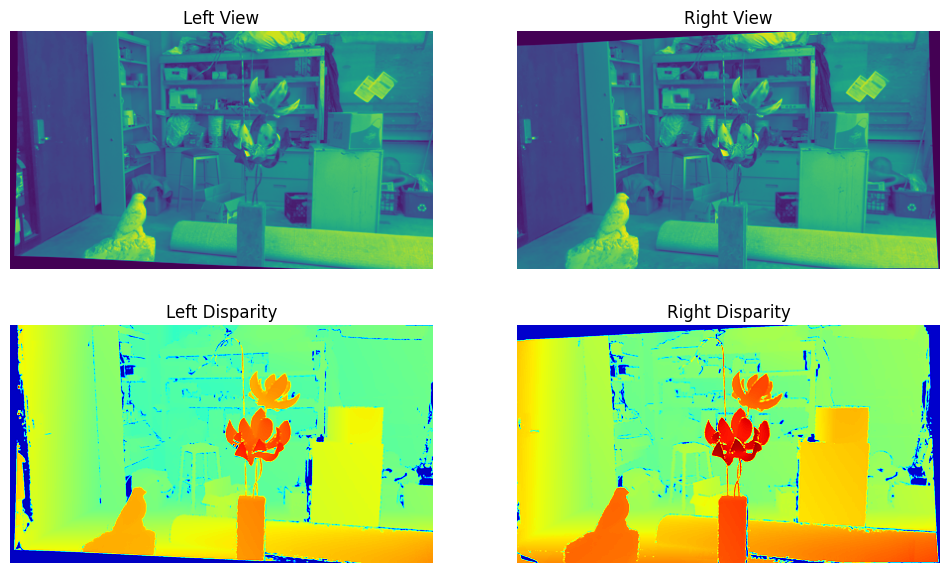

In [14]:
# Almost Quarter of Original Size
new_size = ( 427, 240)

ndisp_resized = int( calib[ "ndisp"] / 4)

disp_L_resized = np.array( Image.fromarray( disp_L).resize( new_size))
disp_R_resized = np.array( Image.fromarray( disp_R).resize( new_size))

img_L_resized = np.array( Image.fromarray( img_L).resize( new_size)) / 255
img_R_resized = np.array( Image.fromarray( img_R).resize( new_size)) / 255

fig = plt.figure( figsize=( 12, 7))

fig.add_subplot( 2, 2, 1)
plt.imshow( img_L_resized)
plt.title( "Left View")
plt.axis( "off")

fig.add_subplot( 2, 2, 2)
plt.imshow( img_R_resized)
plt.title( "Right View")
plt.axis( "off")

fig.add_subplot( 2, 2, 3)
plt.imshow( disp_L_resized, cmap="jet")
plt.title( "Left Disparity")
plt.axis( "off")

fig.add_subplot( 2, 2, 4)
plt.imshow( disp_R_resized, cmap="jet")
plt.title( "Right Disparity")
plt.axis( "off")

plt.show()

##### Scale the range of true resized disparity into [0-1]

In [15]:
disp_L_resized_scaled = np.float32( disp_L_resized - disp_L_resized.min()) / np.float32( disp_L_resized.max())

disp_R_resized_scaled = np.float32( disp_R_resized - disp_R_resized.min()) / np.float32( disp_R_resized.max())

- Disparity using SAD cost function

SSIM with Left Disparity: 0.1721522822804286
SSIM with Right Disparity: 0.2017024179188702
Mean SSIM: 0.1869273500996494


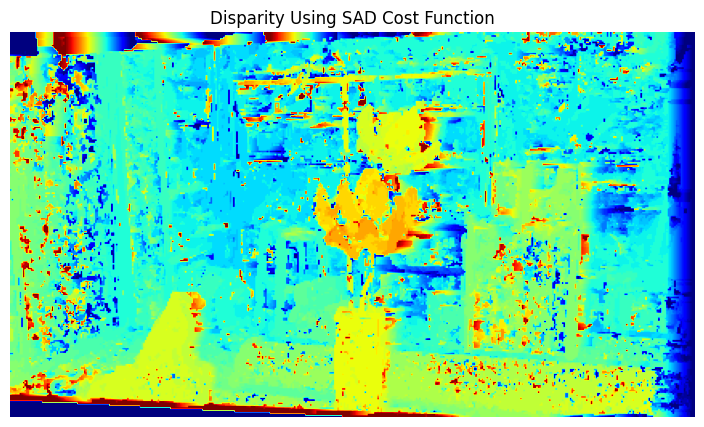

In [16]:
disp = block_matching( img_R_resized, img_L_resized, SAD, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using SAD Cost Function")
plt.axis( "off")
plt.show()

- Disparity using SSD cost function

SSIM with Left Disparity: 0.17246329241556022
SSIM with Right Disparity: 0.20276295533816796
Mean SSIM: 0.18761312387686407


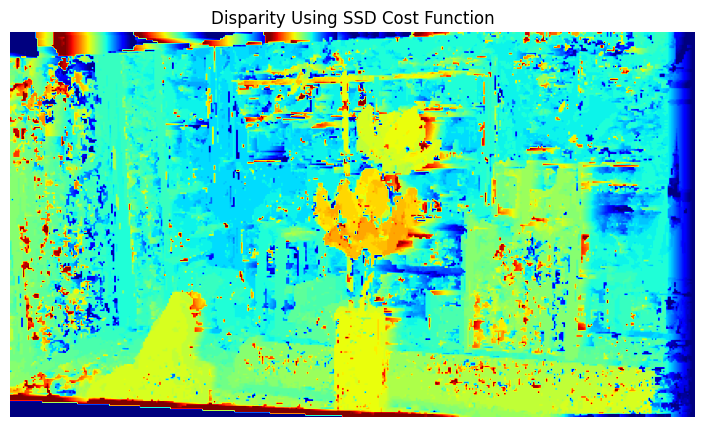

In [17]:
disp = block_matching( img_R_resized, img_L_resized, SSD, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using SSD Cost Function")
plt.axis( "off")
plt.show()

- Disparity using NCC cost function

SSIM with Left Disparity: 0.04868629214231685
SSIM with Right Disparity: 0.06968568741790446
Mean SSIM: 0.05918598978011065


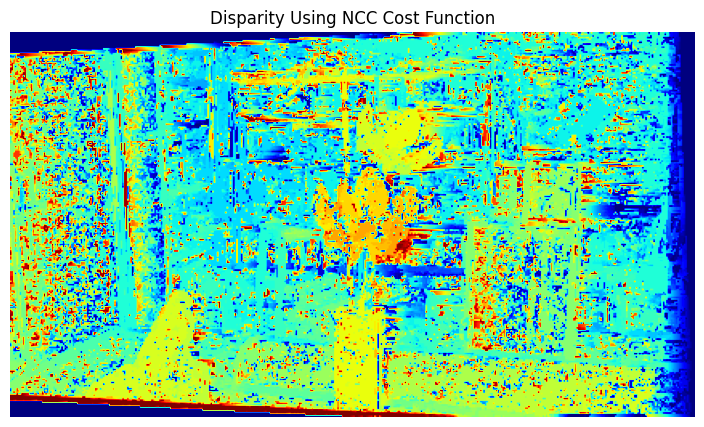

In [18]:
disp = block_matching( img_R_resized, img_L_resized, NCC, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using NCC Cost Function")
plt.axis( "off")
plt.show()

- Disparity using LoG_SAD cost function

SSIM with Left Disparity: 0.04786482840386857
SSIM with Right Disparity: 0.05847358838362124
Mean SSIM: 0.05316920839374491


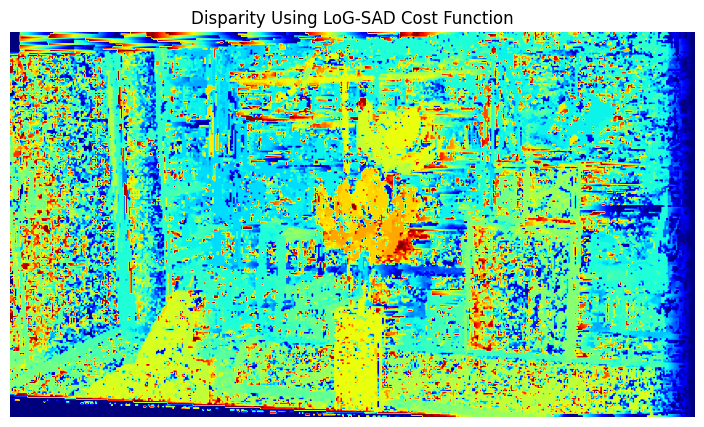

In [19]:
disp = block_matching( img_R_resized, img_L_resized, LoG_SAD, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using LoG-SAD Cost Function")
plt.axis( "off")
plt.show()

- Disparity using LoG_SSD cost function

SSIM with Left Disparity: 0.052005547652790765
SSIM with Right Disparity: 0.06070820917414291
Mean SSIM: 0.056356878413466836


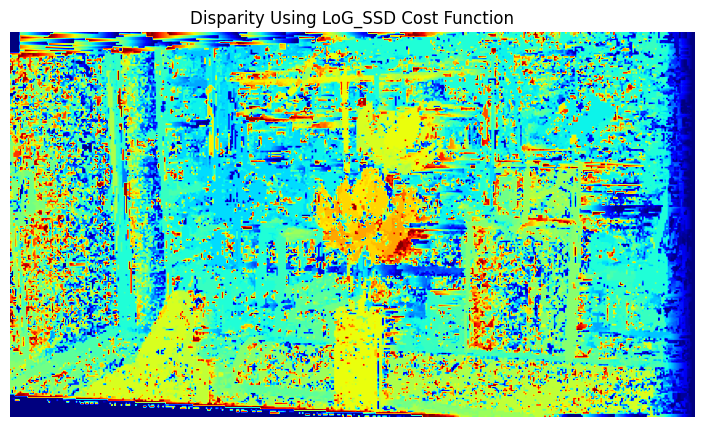

In [20]:
disp = block_matching( img_R_resized, img_L_resized, LoG_SSD, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using LoG_SSD Cost Function")
plt.axis( "off")
plt.show()